This notebook is inspired by a [blog post](https://engineering.snapp.ir/نمایش-نقاط-پرتکرار-برای-مسافران-اسنپ-n9pzjaym2wgo) by tech team at "[Snap](https://en.wikipedia.org/wiki/Snapp!)" (a popular ride hailing service in Iran). 

**Frequent Pins Feature for Car Hailing**

Snap has added a new feature for recommending most frequent pins of a user when they want to get a ride. This feature is different from the user bookmarking particular points on map as "*favourite places*". The objective behind this feature is reducing the time user spends on fixing the pins on the map.


**Pupolarity with Users**

Accourding to Snap team, the new feature has been quite popular with the users.
For assessing the usability of the new feature, Snap used A/B testing, and discussed two of the metrics they used for the analysis in their blog post. First, the time from "showing map" to "select pin on map" was reduced 7% (for users who had the new feature, compared to those who didn't). Second, the number of times "frequent pins" was used over "favourite places". The second metric was reported 64% and 40% for source and destination pins, respectively. Thus,  Snap stated that the new feature has been one of the most successful projects of the team.


**Implementing the Idea in This Notebook**

The blogpost describes the steps taken for implementing the new features. Here, I tried to do something similar with dataset of [Uber Peru riders in 2010](https://www.kaggle.com/marcusrb/uber-peru-dataset). The dataset includes user ids along with latitude and longitude of source and destination for the rides. The content of the notebook is as follows:

- Data Preprocessing
- Clustering
  - DBSCAN vs. KMeans
  - Comparing for loop vs. multiprocessing execution time
- Visualization



In [2]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [63]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

import os
from multiprocessing.pool import Pool

from math import radians,degrees
from typing import Tuple
from sklearn.cluster import DBSCAN,KMeans
from sklearn.metrics.pairwise import haversine_distances
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils.testing import ignore_warnings

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline

# Data Preprocessing

In [48]:
uber_df = pd.read_csv("uber_peru_2010.csv",delimiter=";")

In [49]:
uber_df.columns

Index(['journey_id', 'user_id', 'driver_id', 'taxi_id', 'icon', 'start_type',
       'start_at', 'start_lat', 'start_lon', 'end_at', 'end_lat', 'end_lon',
       'end_state', 'driver_start_lat', 'driver_start_lon', 'arrived_at',
       'currency', 'price', 'price_distance', 'price_duration', 'distance',
       'duration', 'cost', 'cost_distance', 'cost_duration', 'source',
       'driver_score', 'rider_score'],
      dtype='object')

In [50]:
# profile = ProfileReport(uber_df, title="Pandas Profiling Report",minimal=True)
# profile.to_widgets()

Pandas profiling detected missing values for some of the columns. However, since for this notebook I will only use a handful of the columns, I won't preprocess the redundant columns.

In [51]:
uber_df = uber_df[['journey_id', 'user_id','start_lat', 'start_lon','end_lat', 'end_lon']]

In [52]:
uber_df.describe()

,journey_id,user_id,start_lat,start_lon,end_lat,end_lon
count,23111,23111,23111,23111,23111,23111
unique,23111,1390,11753,8489,12266,9084
top,649d38ea6680a3f6ee4a4b734f6a5895,a86c8d399be95a32f795a8a9887127b9,"-12,098176","-76,971417","-12,1175","-77,0430556"
freq,1,834,690,690,466,466


In [53]:
user_journey_count = uber_df.groupby(["user_id"])["journey_id"].count()

In [54]:
user_journey_count.mean()

16.62661870503597

On average, a user has around 17 rides recoreded in this dataset.

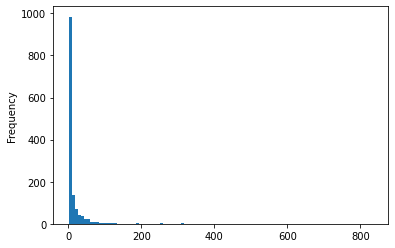

In [55]:
user_journey_count.plot.hist(bins=100)
plt.show()

The lat and lon columns are stored as string values, in form of -xx,xxxx but valid lat and lon values must be floats where -90<=lat<=90 and -180<=lon<=180. So we'll transform them into desired format.

In [56]:
def latlon_string_to_decimal_degree(row:pd.Series)->pd.Series:
    for col in ["start_lat","start_lon","end_lat","end_lon"]:
      row[col] = float(row[col].replace(",","."))
    return row

def is_location_valid(lat: float, lon: float) -> bool:
    '''
    :param lat: latitude
    :param lon: longitude
    :return: True if latitude and longitude are in valid range, False otherwise.
    '''
    try:
        result = bool(lat >= -90 and lat <= 90 and lon >= -180 and lon <= 180)
    except TypeError:
        result = False
    return result

In [57]:
uber_df = uber_df.apply(latlon_string_to_decimal_degree, axis=1)

Then, we'll see if the new values are valid latitude and longitudes.

In [58]:
uber_df['is_location_valid'] = uber_df.apply(lambda x: is_location_valid(x.start_lat, x.start_lon) and is_location_valid(x.end_lat, x.end_lon) , axis=1)

In [59]:
uber_df[~uber_df['is_location_valid']]

,journey_id,user_id,start_lat,start_lon,end_lat,end_lon,is_location_valid


# Clustering

## DBSCAN vs. K-Means

Snap utilized DBSCAN algorithm to cluster users' pins (both source and destination). Minimum pins in each cluster is 2, and maximum distance for two nieghbors is 100 meters (defined by Snap).

Snap described that they prefered DBSCAN over K-Means because there is no need to define number of clusters. Furthermore, DBSCAN looks for density as well as distance and it can handle clusters with complex shapes.

An example shared in the blog post was the following taken from[ Towards Data Science](https://towardsdatascience.com/dbscan-clustering-for-data-shapes-k-means-cant-handle-well-in-python-6be89af4e6ea)


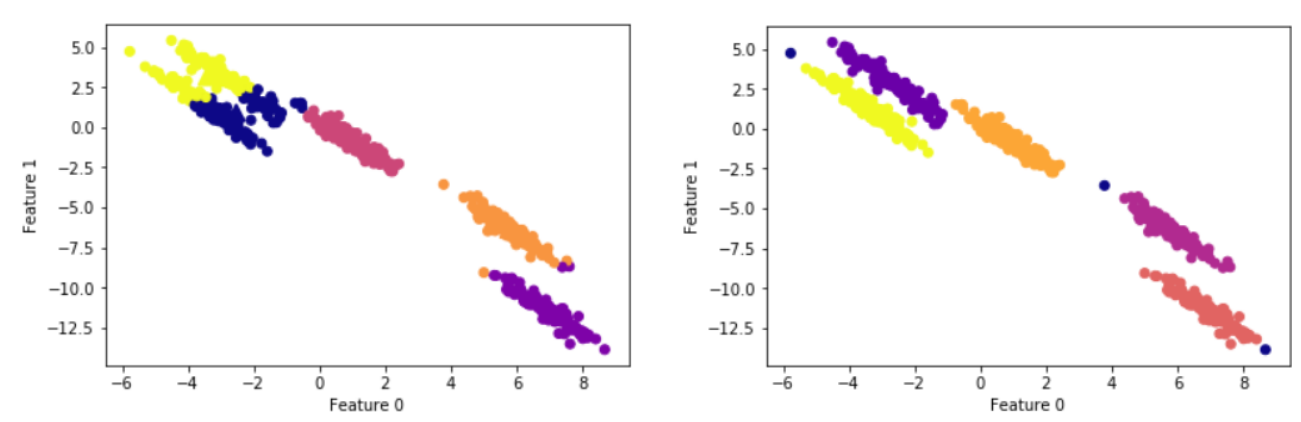

The picture on the left shows K-MEANS clustering, and the right one is DBSCAN results. We can see that K-Means only cares about distance, and two of the clusters are mixed. In the context of streets and map pins, it would be as if two separate streets are mixed and defined as one cluster.

For the sake of comparison, we will use both of the afromentioned algorithms and compare their final result. For K-Means, I set the number of clusters to 5. (unless the no. samples are smaller, in which case the k is set to the number of samples. This raised a lot of convergence warnings, and I disabled the warnings. Alternatively, we could only calculate clusters only for users who have had a considerable number of riedes already).

In [64]:
# ignore convergence warnings for Kmeans with small number of samples
@ignore_warnings(category=ConvergenceWarning)
def cluster_pins(pins_in_radians:np.array)->Tuple[np.array,np.array,np.array]:
  '''
  :param pins_in_radians: lat and lon np.array in radians (used for haversine distance metric for DBSCAN)
  :returns: tuple of dbscan labels, kmeans labels, and kmeans cluster centers

  This function calculates both DBSCAN and KMEANS clustering restuls for given user pins
  
  For DBSCAN, the hyperparameters are set based on the blog post by Snap (min_samples=2, eps=100 meters)
  Haversine metric is used to get the distance between geo points in radians

  
  For Kmeans, the number of clusters is 5 unless the no. samples are smaller, in which case the k is set to the number of samples
  '''

  R=6371000# radius of Earth in meters
  distance = 100/R # distance*(radius of Earth in meters)<100 --> disctance<100/(radius of Earth in meters)

  #DBSCAN
  dbscan = DBSCAN(eps=distance, min_samples=2,metric="haversine").fit(pins_in_radians)

  #KMEANS
  n_samples = len(pins_in_radians)
  kmeans = KMeans(n_clusters=5 if n_samples>=5 else n_samples , random_state=0).fit(pins_in_radians)

  return dbscan.labels_,kmeans.labels_,kmeans.cluster_centers_

def get_pins_from_rides(rides_df:pd.DataFrame)->np.array:
  '''
  :param rides_df: dataframe of user rides with "start_lat", "start_lon, "end_lat", and "end_lot" columns
  :returns: a numpy array with size (no.rides*2) x 2, where each element is a lat and lon pair

  The dataframe of rides is broken into an array of lat and lon
  '''
  pins = np.concatenate((rides_df[["start_lat","start_lon"]].to_numpy(),
                         rides_df[["end_lat","end_lon"]].to_numpy()),
                        axis=0)
  return pins

def cluster_rides(rides_df)->Tuple[pd.DataFrame,pd.DataFrame, pd.DataFrame]:
  '''
  :param rides_df: dataframe of all rides for a single user
  :returns: a dataframe with all user pins and their corresponding labels by DBSCAN and KMeans, DBSCAN and Kmeans centers
  '''
  pins= get_pins_from_rides(rides_df)
  # get the radian value of lat and lon, required for Haversine distance metric for DBSCAN
  pins_in_radians = [[radians(pin[0]),radians(pin[1])] for pin in pins]
  dbscan_labels, kmeans_labels,kmeans_centroids = cluster_pins(pins_in_radians)
  pins_df = pd.DataFrame({'lat': pins[:, 0], 'lon': pins[:, 1],'dbscan_label':dbscan_labels,'kmeans_label':kmeans_labels})
  # change type of labels, for sake of showing descrete colors on map
  pins_df = pins_df.astype({'dbscan_label': 'string', 'kmeans_label': 'string'})
  # The blog post did not describe what value they show as suggested pin for a cluster
  # so we'll get the mean of the cluster to show as "recommendation" on map
  # ther is a chance that the final mean wouldn't be a valid point on map
  unique_labels = np.unique(dbscan_labels)
  unique_labels = unique_labels[unique_labels != -1] #don't get noises
  dbscan_centroids = [np.mean(np.take(pins, np.argwhere(dbscan_labels==label).reshape(1,-1)[0], axis=0), axis=0) for label in unique_labels]
  dbscan_centroids_df = pd.DataFrame({'lat': [centroid[0] for centroid in dbscan_centroids], 'lon':[centroid[1] for centroid in dbscan_centroids],
                                   'label':unique_labels})
  dbscan_centroids_df = dbscan_centroids_df.astype({'label': 'string'})

  kmeans_centroids_df = pd.DataFrame({'lat': [degrees(centroid[0]) for centroid in kmeans_centroids], 'lon':[degrees(centroid[1]) for centroid in kmeans_centroids],
                                   'label':range(len(kmeans_centroids))})
  kmeans_centroids_df = kmeans_centroids_df.astype({'label': 'string'})
  return pins_df,dbscan_centroids_df,kmeans_centroids_df

## For Loop vs. Multi-processing

In [61]:
unique_users = uber_df['user_id'].unique()

Snap does not calculate the recommendations in real-time, instead, as described in the blog, they use Apache Spark parallel computing solution to calculate the frequent pins for millions of users on a weekly basis. For the sake of doing someting a TINY bit close to that idea (!), and a bit of self-practice with pythong multi-processing, I tried both a simple for loop and multiprocessing to compare the execution time.

In [65]:
%%time
user_frequent_pins = {user_id:cluster_rides(uber_df[uber_df['user_id']==user_id]) for user_id in unique_users}

CPU times: user 57.2 s, sys: 1.15 s, total: 58.3 s
Wall time: 57 s


In [66]:
print(os.cpu_count())
p = Pool()

2


In [67]:
%%time
result= p.map(cluster_rides, [uber_df[uber_df['user_id']==user_id] for user_id in unique_users])       
p.close()
p.join()

CPU times: user 6.74 s, sys: 265 ms, total: 7.01 s
Wall time: 49.3 s


Multiprocessing with two cores is a tiny bit faster than the for loop.

# Visualization

In the preprocessing, we say than average user has 17 rides in the datset. For the sake of having more pins to play with, we choose one of the "loyal" costumers who has had at least 100 rides.

In [68]:
loyal_costumer = user_journey_count.where(user_journey_count>100).sort_values().index[0]
loyal_costumer_clusters, dbscan_centroids,kmeans_centroids = user_frequent_pins[loyal_costumer]

In [69]:
# get a discrete color map for labels, (label+1) part is for avoiding index out of bound for -1 label of DBSCAN noises
color_discrete_map = {label:px.colors.qualitative.Light24[(int(label)+1)%24] for label in loyal_costumer_clusters["dbscan_label"].unique()}


I couldn't use pretty symbols on map without Mapbox token, so the frequent pins will be big circles on map :)

In [70]:
dbscan_fig = px.scatter_mapbox(loyal_costumer_clusters, lat="lat", lon="lon", color='dbscan_label',zoom=10,
                               color_discrete_map=color_discrete_map)

pin_recommendations = (px.scatter_mapbox(dbscan_centroids,lat='lat' ,lon ='lon', color= 'label',size=[10]*dbscan_centroids.shape[0],size_max=10,
                                         color_discrete_map=color_discrete_map,opacity=0.5))

dbscan_fig.add_traces(pin_recommendations.data)

dbscan_fig.update_layout(mapbox_style="carto-positron")
dbscan_fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
dbscan_fig.show()

In [72]:
kmeans_fig = px.scatter_mapbox(loyal_costumer_clusters, lat="lat", lon="lon", color='kmeans_label',
                               zoom=10,color_discrete_map=color_discrete_map)
kmeans_fig.update_layout(mapbox_style="carto-positron")
pin_recommendations = (px.scatter_mapbox(kmeans_centroids,lat='lat' ,lon ='lon', color= 'label',
                                         size=[10]*kmeans_centroids.shape[0],size_max=10,color_discrete_map=color_discrete_map))

kmeans_fig.add_traces(pin_recommendations.data)
kmeans_fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
kmeans_fig.show()

The Kmeans clusters are much bigger, with each cluster including a big chunk of map. It is not practical to define the no. of clusters per user to get well-defined cluders useful for recommending pins. DBSCAn clusters, on the other hand, make more sense in this example.

(pics on left are DBSCAN, right is K-Means. Also, I disabled the noises (label==-1) on DBSCAN visualizaiton)

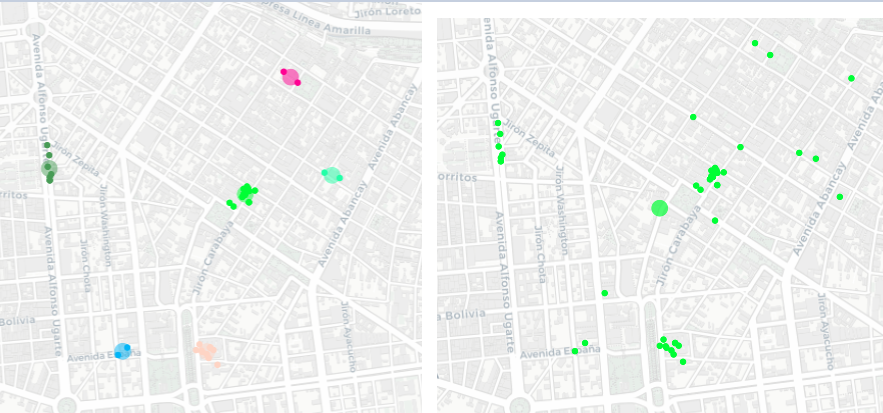

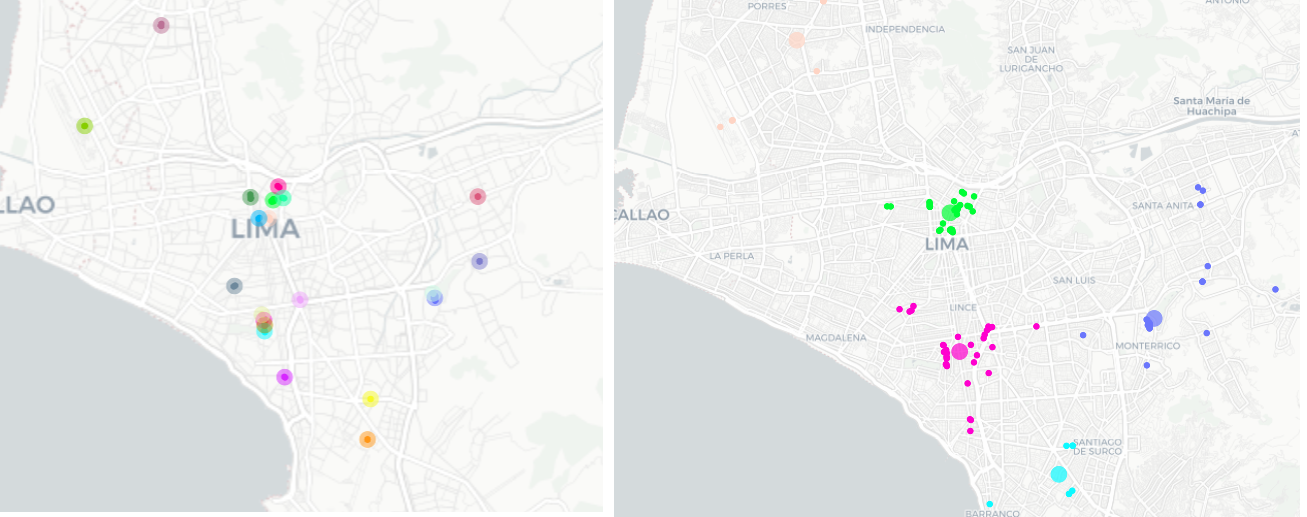